In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

#### Set parameters

In [2]:
elec_pos = params.ELECTRODE_POSITION #pos = np.column_stack((x,y,z))
loc_param = [0,0,50,np.pi/4,1,0]  # position (x,y,z,alpha,h,phi)
geo_param = [8.,600.,1.25,.28,.28,200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])
geo_name = ['soma r','trunk l','trunk r','basal r','tuft r','dend l']
biophys = [-1] # (g_pas of soma, basal, apical, gNaTa_t of soma, apical, gSKv3_1 of soma, apical) (3.3e-5, 6.3e-5, 8.8e-5, 2.43, 0.0252, 0.983, 0.0112)

In [3]:
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib inline

def sim_builder(geo_var: List[Tuple[int,List[float]]], gmax: float = .01) -> Simulation:
    """ geo_var: List of Tuples ( Parameter entry, List of values ), variable parameters to loop over """
    geo_idx, values = zip(*geo_var)
    geo_params = [x.ravel() for x in np.meshgrid(*values,indexing='ij')]
    ncell = geo_params[0].size
    geo_parameters = np.tile(np.array(geo_param),(ncell,1))
    for idx, val in zip(geo_idx,geo_params):
        geo_parameters[:,idx] = val
    sim = Simulation(geometry = geo_standard, 
                     electrodes = elec_pos, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_parameters, 
                     biophys = biophys, 
                     ncell = ncell, 
                     spike_threshold = 0, 
                     gmax = gmax, 
                     scale = 1.)  # 0.001 -0.012
    geo_values = np.vstack(geo_params).T
    return sim, geo_idx, geo_values

def plot_v(sim: Simulation, geo_idx: Tuple[int], geo_values: np.ndarray,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=sim.ncell, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*sim.ncell)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:],label=', '.join(map(str,geo_values[i])))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title(', '.join([geo_name[i] for i in geo_idx]))
    axs[-1].set_xlabel('Time (ms)')
    return fig, axs

#### Simulation

In [4]:
geo_range = [(0,[5.,12.]),(1,[20.,800.])] # soma r 5-12, trunk l 20-800

In [5]:
sim, geo_idx, geo_values = sim_builder(geo_range,gmax=.01)

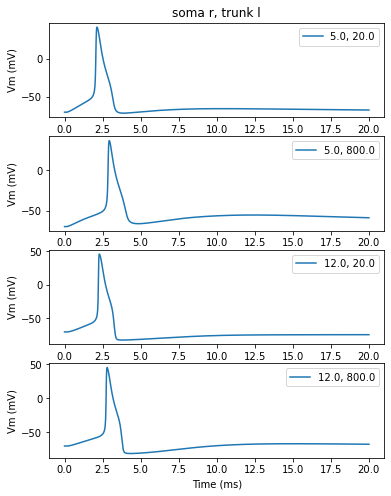

In [6]:
sim.run_neuron_sim()
_ = plot_v(sim, geo_idx, geo_values)

Change gmax

In [7]:
gmax = 0.03
sim.set_gmax(gmax)

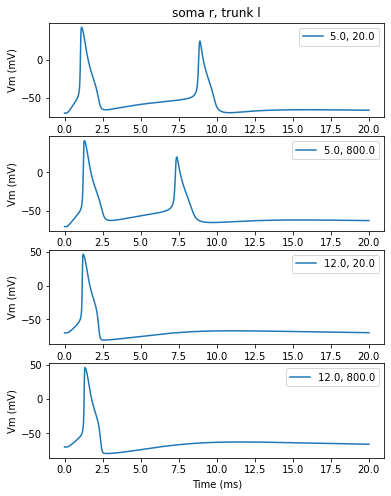

In [8]:
sim.run_neuron_sim()
_ = plot_v(sim, geo_idx, geo_values)

In [10]:
# get number of spikes of each cell
sim.get_spike_number('all')

array([2, 2, 1, 1])